#**FOR WORKING PURPOSES ONLY:**

Plan:

**1. Generate Square Lattice Data**
2. Create a Fully-Conected Neural Network, achieving 94% accuracy on 10x10 grids.
3. Create a Fully Connected Neural Network, achieving 99% accuracy on 40x40 grids.
4. Create the mentioned Toy Model, with analytically determined parameters.
5. Generate Triangular Lattice Data (L = 30) *(Side Note: They don't seem to train a separate model for each L)*
6. If necessary, train a Fully Connected Neural Network on 30x30 square lattice data.
7. Test out Fully Connected Neural Network on the Triangular Lattice Data.
**8. Generate Square Ice Lattice Data (2 x 16 x 16).**
9. Train Fully Connected Neural Network on Square Ice Lattice Data (100 hidden units..)
**10. Generate Ising Lattice Gauge Theory Lattices (16 x 16 x 2).**
11. Train a Fully-Connected Neural Network on this data, show it only attains 50% accuracy.
12. Train a ConvNet on this data, show it attains nearly 100% accuracy.
13. Modify the testing set to violate the closed-loop structure.
14. Test the ConvNet on this, demonstrate results are still high.
15. Modify the testing set to violate locality constraints.
16. Test the ConvNet on this, demonstrate results are lower.
17. Discuss future extensions, and eventually start implementing them.


In [2]:
import numpy as np
import random
!pip install numba
from numba import jit
import matplotlib.pyplot as plt
!pip install tqdm
from tqdm import tqdm
import pandas as pd

# **Data Generation**

In [3]:
np.random.seed(seed = 3)

Here, we will perform the Metropolis-Hastings Algorithm to generate square lattices.

First, we create this function to calculate the square Hamiltonian for each lattice.

In [4]:
@jit
def ferr_square_energy(lattice):
  en = 0
  for i in range(len(lattice)):
    for j in range(len(lattice)):
      if i>0:
        en -= lattice[i][j]*lattice[i-1][j]
      if i<len(lattice)-1:
        en -= lattice[i][j]*lattice[i+1][j]
      if j>0:
        en -= lattice[i][j]*lattice[i][j-1]
      if j<len(lattice)-1:
        en -= lattice[i][j] * lattice[i][j+1]
  return en

Here, we initialize our constants.

In [5]:
k = (1.38064852)/(10**23) #

Now, we create a function to execute the Metropolis-Hastings Algorithm and collect samples.

In [6]:
from typing import Callable
def metropolis(get_energy: Callable[[np.ndarray], float], grid_size: int, starts: int, samples: int, temp_start: float, temp_end: float, therm_steps: int):
  temp_range = np.linspace(temp_start,temp_end,int(10*(temp_end-temp_start))) #The range of temperatures from 1 to 3.7
  tempList = [] #This collects the specific temperatures for later plotting.
  sampleList = [] #This collects the samples over the Metropolis-Hastings algorithm.

  #For each temperature, for each start, we collect samples collected after thermal evolution. 
  for temp_count in tqdm(range(len(temp_range))):
    temp = temp_range[temp_count]
    #Computing beta.
    b = 1/(k*temp) 
    #Loops through the starts.
    for start in range(starts):
      #Collect each sample.
      for sample in range(samples): 
        #Generates a random lattice of decimals between -1 and 1.
        start_lat = np.array([[2*np.random.uniform() - 1 for count in range(grid_size)] for count2 in range(grid_size)])
        
        #We then define the initial random lattice to have 1s where the decimal is >=0 and -1s where the decimal is <0. 
        lattice = np.zeros((grid_size,grid_size))
        lattice[start_lat>=0] = 1.0
        lattice[start_lat<0] = -1.0
        #This collects all the energies of samples for plotting.
        enList = [] 
        #Here, we will collect iterative times for plotting.
        timeList = []
        #Initializing algorithmic time to 0.
        time = 0
      
        #We perform thermal evolution.
        for therm_step in range(therm_steps):
        
          #Collect the energy of the current lattice.
          curr_en = get_energy(lattice)
          
          #Picks a lattice sites to flip.
          flip_x, flip_y = (random.randint(0,grid_size-1),random.randint(0,grid_size-1))
          
          #We create a candidate state (state_v) that has this site flipped. 
          state_v = lattice.copy()
          state_v[flip_x][flip_y] *=-1
        
          #Here, we evaluate the energy of this candidate.
          v_en = get_energy(state_v)
        
          #Now we calculate the probability that this state will be accepted. If the candidate state has a lower energy than the current state, this probability is 1, else it is the exponentiation of the difference between the candidate and present energy scaled.
          p_uv = 1 if v_en < curr_en else np.exp(-b*(v_en - curr_en))
        
          #We store the algorithmic time and increment it.
          timeList.append(time)
          time += 1
        
          #If a coin toss with this acceptance probability as its distribution produces a 1 (perhaps thought of as a heads), we accept the state.
          if np.random.uniform()<=p_uv:
            lattice = state_v.copy()
        
          #We store the energy of the lattice, for the plotting.
          enList.append(get_energy(lattice))
      
        #Here we store the sample and the current temperature for plotting and sample collection.
        sampleList.append(lattice)
        tempList.append(temp)
        
  return sampleList, tempList, enList, timeList

Now we run Metropolis-Hastings for the Square Lattice to generate 10 x 10 lattices, over 10 starts, taking 100 samples per start per temperatures ranging between 1.0 and 3.7. 100 thermal evolution steps will be taken to simulate the effects of a thermal bath.

In [7]:
sampleList, tempList, enList, timeList = metropolis(ferr_square_energy, 10, 10, 100, 1, 3.7, 100)

100%|██████████| 27/27 [01:03<00:00,  2.34s/it]


**Here, we plot algorithmic time vs the energy of the lattices over the last iteration of thermal evolution in the Metropolis-Hastings Algorithm.**

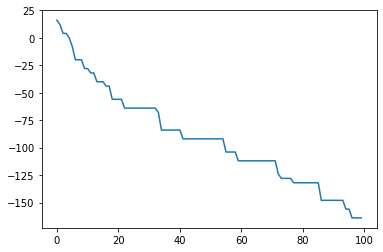

In [8]:
#We plot energy vs algorithmic time.
plt.plot(timeList, enList)

Though it is roughly-hewn, and may appear jittery, the energy decreases consistently over time, which is encouraging.

## **Data Preprocessing**

**Here we preprocess the data by simply flattening the lattices into feature vectors, perform train-test split and store it in a .csv file.**




In [10]:
def train_test_data(sampleList):

  #Here, we flatten the samples into a feature matrix.
  feature_matrix = np.array([features.flatten() for features in sampleList])

  #Set Curie Temperature as 2.27
  Tc = 2.27
  
  #We create another set of temperature values, first reformatting to correct dimensions and marking all temperatures above the critical temperature 1, and all below 0.
  tempList2 = np.array([[temp] for temp in tempList])
  tempList3 = np.zeros(tempList2.shape)
  tempList3[tempList2>=Tc] = 1
  tempList3[tempList2<Tc] = 0
  
  #Now, we append the target column (1/0 to indicate temp above or below the critical temperature) to the feature matrix.
  feature_matrix = np.append(feature_matrix, tempList3, axis = 1)
  
  #We shuffle the feature matrix so that the neural network doesn't pick up any pattern around the temperature-ordered way we generated the data.
  np.random.shuffle(feature_matrix) #
  
  #Here, we perform train-test split, and pick 4/5 of the data for training and 1/5 for testing.
  end = 4 * len(feature_matrix) // 5
  feature_train_matrix = feature_matrix[:end, :-1]
  feature_test_matrix = feature_matrix[end:, :-1]
  
  tempList2 = feature_matrix[:,-1]
  
  tempList2 = [int(temp) for temp in tempList2]
  y_train = tempList2[:end]
  
  y_test = tempList2[end:]
  
  #Here, we return the training and testing data.
  return feature_train_matrix, np.expand_dims(np.array(y_train), axis = 1), feature_test_matrix, np.expand_dims(np.array(y_test), axis = 1)

feature_train_matrix, y_train, feature_test_matrix, y_test = train_test_data(sampleList)

#Uncomment the code below to store the data into a csv file.

#csv_train = pd.DataFrame(feature_train_matrix)
#csv_train["y_train"] = y_train
#csv_train = csv_train.to_csv("square_csv_train.csv")
#csv_test = pd.DataFrame(feature_test_matrix)
#csv_test["y_test"] = y_test
#csv_test = csv_test.to_csv("square_csv_test.csv")

#These lines of code can be uncommented to download the csv files.

#from google.colab import files
#files.download("csv_train.csv")
#files.download("csv_test.csv")

## **Feedforward Neural Network for Square Lattice Phase Transitions**

**Here, we construct our first Neural Network.**

Here we create a class defining a LinearModel Neural Network with dimensions as specified in paper, input layer of grid_size * grid_size x 100 and a hidden layer of 100 x 2, including a non-linear sigmoid activation.

In [11]:
import torch.nn as nn
from torch.nn import Sigmoid
from torch.optim import Adam
import torch
from torch import Tensor
from torch import from_numpy

grid_size = 10

class LinearModel(nn.Module): 
    def __init__(self):
        super(LinearModel, self).__init__()          
        self.fc_1 = nn.Linear(grid_size*grid_size, 100)    
        self.fc_2 = nn.Linear(100, 2)
            
    def forward(self, X):    
        output = self.fc_1(X)
        output = nn.Sigmoid()(output)
        output = self.fc_2(output)
        output = nn.Sigmoid()(output)
        return output

**Training:**

Here we train the model on the training data using Cross-Entropy Loss with Adam-based optimization.

In [ ]:
def flip(n):
  if n == 1:
    return 0
  else:
    return 1

In [13]:
features_train = feature_train_matrix.copy()
target_train = y_train.copy()
optalg = Adam
epochs = 1000
batch_size = 128
#We convert the numpy data to a PyTorch Tensor to be compatible with the neural network.
y_train_torch = torch.from_numpy(target_train)
y_train_torch = y_train_torch.type(torch.LongTensor)
feature_train_matrix_torch = torch.from_numpy(features_train)
feature_test_matrix_torch = torch.Tensor(feature_test_matrix)
y_test_torch = torch.Tensor(y_test).type(torch.LongTensor)



#The grid_size is merely the square root of the length of each example, since its features are the list of all lattice sites.
grid_size = int(np.sqrt(len(features_train[0])))

#We run some number of Epochs of training.
EPOCHS = epochs

#Here we instantiate a Linear Model and set it to train mode.
model = LinearModel()
model.train()

#We set the criterion to be CrossEntropyLoss and the optimizer Adam.
criterion = nn.CrossEntropyLoss() #Also tried BCELoss, to similar effect.
optimizer = optalg(model.parameters(), lr = 10**-5, weight_decay = 0.01)

#Initialize the list of accuracies for plotting purposes.
acc_list = []
test_acc_list = []
#Initialize the list of epochs for plotting purposes.
ep_li = []
predictions = []

#For each epoch
for ep in tqdm(range(1, EPOCHS + 1)):
  acc = 0
  ep_li.append(ep)
  rand_perms = torch.randperm(feature_train_matrix_torch.shape[0])
  
  #for each training example, extract the example's features, set the optimizer to zero_gradient mode.

  for i in range(0, rand_perms.shape[0], batch_size):
    current_indices = rand_perms[i:i+batch_size]
    current_features = feature_train_matrix_torch[current_indices].type(torch.FloatTensor)
    current_targets = y_train_torch[current_indices].type(torch.LongTensor)
    optimizer.zero_grad()

    out = model.forward(current_features)
    
    label = nn.functional.one_hot(current_targets.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)

    acc+= list(torch.argmax(label, 1) - torch.argmax(out, 1)).count(0)
    
    #Calculate the loss via binary cross entropy.
    loss = criterion(out,label)
    #Perform backward propagation to improve the weights, on this loss function.
    loss.backward()
    #Step the optimizer.
    optimizer.step()
  
  #Testing Step
  test_out = model.forward(feature_test_matrix_torch)
  test_label = nn.functional.one_hot(y_test_torch.type(torch.LongTensor), num_classes = 2).type(torch.FloatTensor).squeeze(1)
  test_acc = list(torch.argmax(test_label, 1) - torch.argmax(test_out, 1)).count(0)

  print("\nTRAIN ACCURACY: ", 100 * acc/len(y_train_torch))
  print("TEST ACCURACY: ", 100* test_acc/len(y_test_torch))

  acc_list.append(100*acc/len(y_train_torch))
  test_acc_list.append(100*test_acc/len(y_test_torch))
  ep_li.append(ep)

  0%|          | 1/1000 [00:00<09:39,  1.73it/s]


TRAIN ACCURACY:  51.94444444444444
TEST ACCURACY:  50.870370370370374


  0%|          | 2/1000 [00:00<07:40,  2.17it/s]


TRAIN ACCURACY:  52.013888888888886
TEST ACCURACY:  51.03703703703704


  0%|          | 3/1000 [00:01<07:03,  2.35it/s]


TRAIN ACCURACY:  52.06481481481482
TEST ACCURACY:  51.129629629629626


  0%|          | 4/1000 [00:01<06:48,  2.44it/s]


TRAIN ACCURACY:  52.05555555555556
TEST ACCURACY:  51.148148148148145


  0%|          | 5/1000 [00:02<06:42,  2.47it/s]


TRAIN ACCURACY:  52.0462962962963
TEST ACCURACY:  51.2037037037037


  1%|          | 6/1000 [00:02<06:35,  2.51it/s]


TRAIN ACCURACY:  52.0462962962963
TEST ACCURACY:  51.166666666666664


  1%|          | 7/1000 [00:02<06:26,  2.57it/s]


TRAIN ACCURACY:  52.041666666666664
TEST ACCURACY:  51.166666666666664


  1%|          | 8/1000 [00:03<06:17,  2.63it/s]


TRAIN ACCURACY:  52.041666666666664
TEST ACCURACY:  51.166666666666664


  1%|          | 9/1000 [00:03<06:19,  2.61it/s]


TRAIN ACCURACY:  52.03703703703704
TEST ACCURACY:  51.148148148148145


  1%|          | 10/1000 [00:04<06:16,  2.63it/s]


TRAIN ACCURACY:  52.03703703703704
TEST ACCURACY:  51.148148148148145


  1%|          | 11/1000 [00:04<06:09,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  1%|          | 12/1000 [00:04<06:13,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  1%|▏         | 13/1000 [00:05<06:10,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  1%|▏         | 14/1000 [00:05<06:08,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 15/1000 [00:05<06:09,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 16/1000 [00:06<06:06,  2.69it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 17/1000 [00:06<06:08,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 18/1000 [00:06<06:07,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 19/1000 [00:07<06:07,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 20/1000 [00:07<06:11,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 21/1000 [00:08<06:08,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 22/1000 [00:08<06:19,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 23/1000 [00:08<06:15,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▏         | 24/1000 [00:09<06:10,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  2%|▎         | 25/1000 [00:09<06:12,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 26/1000 [00:10<06:10,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 27/1000 [00:10<06:08,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 28/1000 [00:10<06:09,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 29/1000 [00:11<06:04,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 30/1000 [00:11<06:01,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 31/1000 [00:11<06:01,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 32/1000 [00:12<06:01,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 33/1000 [00:12<06:01,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  3%|▎         | 34/1000 [00:13<06:02,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▎         | 35/1000 [00:13<05:59,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▎         | 36/1000 [00:13<05:58,  2.69it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▎         | 37/1000 [00:14<06:33,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 38/1000 [00:14<06:19,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 39/1000 [00:15<06:12,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 40/1000 [00:15<06:06,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 41/1000 [00:15<06:04,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 42/1000 [00:16<06:03,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 43/1000 [00:16<06:00,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 44/1000 [00:16<06:00,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  4%|▍         | 45/1000 [00:17<05:58,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▍         | 46/1000 [00:17<05:56,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▍         | 47/1000 [00:17<05:57,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▍         | 48/1000 [00:18<05:55,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▍         | 49/1000 [00:18<05:54,  2.69it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▌         | 50/1000 [00:19<06:02,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▌         | 51/1000 [00:19<06:00,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▌         | 52/1000 [00:19<05:57,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▌         | 53/1000 [00:20<05:59,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  5%|▌         | 54/1000 [00:20<05:56,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 55/1000 [00:21<05:55,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 56/1000 [00:21<05:52,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 57/1000 [00:21<05:54,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 58/1000 [00:22<05:59,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 59/1000 [00:22<05:56,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 60/1000 [00:22<05:54,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 61/1000 [00:23<05:58,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▌         | 62/1000 [00:23<05:57,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▋         | 63/1000 [00:24<06:01,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▋         | 64/1000 [00:24<05:59,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  6%|▋         | 65/1000 [00:24<05:56,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 66/1000 [00:25<05:59,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 67/1000 [00:25<05:58,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 68/1000 [00:25<05:57,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 69/1000 [00:26<05:59,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 70/1000 [00:26<05:58,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 71/1000 [00:27<05:59,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 72/1000 [00:27<05:56,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 73/1000 [00:28<06:28,  2.39it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  7%|▋         | 74/1000 [00:28<06:21,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 75/1000 [00:28<06:09,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 76/1000 [00:29<06:15,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 77/1000 [00:29<06:03,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 78/1000 [00:29<05:58,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 79/1000 [00:30<05:53,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 80/1000 [00:30<05:49,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 81/1000 [00:31<05:44,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 82/1000 [00:31<05:48,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 83/1000 [00:31<05:44,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 84/1000 [00:32<05:43,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  8%|▊         | 85/1000 [00:32<05:43,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▊         | 86/1000 [00:32<05:40,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▊         | 87/1000 [00:33<05:42,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 88/1000 [00:33<05:40,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 89/1000 [00:34<05:39,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 90/1000 [00:34<05:42,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 91/1000 [00:34<05:39,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 92/1000 [00:35<05:40,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 93/1000 [00:35<05:39,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


  9%|▉         | 94/1000 [00:35<05:38,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|▉         | 95/1000 [00:36<05:37,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|▉         | 96/1000 [00:36<05:39,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|▉         | 97/1000 [00:37<05:38,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|▉         | 98/1000 [00:37<05:42,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|▉         | 99/1000 [00:37<05:38,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 100/1000 [00:38<05:38,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 101/1000 [00:38<05:38,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 102/1000 [00:38<05:38,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 103/1000 [00:39<05:37,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 104/1000 [00:39<05:44,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 10%|█         | 105/1000 [00:40<05:39,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 106/1000 [00:40<05:40,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 107/1000 [00:40<05:37,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 108/1000 [00:41<05:35,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 109/1000 [00:41<06:08,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 110/1000 [00:42<05:59,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 111/1000 [00:42<05:50,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█         | 112/1000 [00:42<05:45,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█▏        | 113/1000 [00:43<05:40,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 11%|█▏        | 114/1000 [00:43<05:38,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 115/1000 [00:43<05:35,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 116/1000 [00:44<05:32,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 117/1000 [00:44<05:34,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 118/1000 [00:45<05:32,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 119/1000 [00:45<05:31,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 120/1000 [00:45<05:30,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 121/1000 [00:46<05:29,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 122/1000 [00:46<05:27,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 123/1000 [00:46<05:26,  2.69it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▏        | 124/1000 [00:47<05:26,  2.68it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 12%|█▎        | 125/1000 [00:47<05:27,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 126/1000 [00:48<05:26,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 127/1000 [00:48<05:27,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 128/1000 [00:48<05:28,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 129/1000 [00:49<05:27,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 130/1000 [00:50<07:16,  1.99it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 131/1000 [00:50<06:54,  2.09it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 132/1000 [00:50<06:28,  2.23it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 133/1000 [00:51<06:09,  2.35it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 13%|█▎        | 134/1000 [00:51<05:54,  2.44it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▎        | 135/1000 [00:51<05:45,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▎        | 136/1000 [00:52<05:38,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▎        | 137/1000 [00:52<05:35,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 138/1000 [00:53<05:33,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 139/1000 [00:53<05:31,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 140/1000 [00:53<05:31,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 141/1000 [00:54<05:30,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 142/1000 [00:54<05:31,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 143/1000 [00:55<05:33,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 144/1000 [00:55<05:26,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 14%|█▍        | 145/1000 [00:55<06:00,  2.37it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▍        | 146/1000 [00:56<05:48,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▍        | 147/1000 [00:56<05:39,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▍        | 148/1000 [00:57<05:33,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▍        | 149/1000 [00:57<05:30,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▌        | 150/1000 [00:57<05:27,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▌        | 151/1000 [00:58<05:28,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▌        | 152/1000 [00:58<05:23,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▌        | 153/1000 [00:59<07:19,  1.93it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 15%|█▌        | 154/1000 [00:59<06:40,  2.11it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 155/1000 [01:00<06:22,  2.21it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 156/1000 [01:00<06:08,  2.29it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 157/1000 [01:00<05:50,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 158/1000 [01:01<05:45,  2.44it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 159/1000 [01:01<05:38,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 160/1000 [01:02<05:34,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 161/1000 [01:02<05:26,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▌        | 162/1000 [01:02<05:23,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▋        | 163/1000 [01:03<05:21,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▋        | 164/1000 [01:03<05:18,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 16%|█▋        | 165/1000 [01:03<05:13,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 166/1000 [01:04<05:14,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 167/1000 [01:04<05:14,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 168/1000 [01:05<05:15,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 169/1000 [01:05<05:19,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 170/1000 [01:05<05:16,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 171/1000 [01:06<05:18,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 172/1000 [01:06<05:16,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 173/1000 [01:07<05:17,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 17%|█▋        | 174/1000 [01:07<05:17,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 175/1000 [01:07<05:14,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 176/1000 [01:08<05:16,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 177/1000 [01:08<05:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 178/1000 [01:08<05:13,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 179/1000 [01:09<05:16,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 180/1000 [01:09<05:12,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 181/1000 [01:10<05:41,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 182/1000 [01:10<05:40,  2.41it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 183/1000 [01:10<05:29,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 184/1000 [01:11<05:22,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 18%|█▊        | 185/1000 [01:11<05:15,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▊        | 186/1000 [01:12<05:11,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▊        | 187/1000 [01:12<05:13,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 188/1000 [01:12<05:08,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 189/1000 [01:13<05:07,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 190/1000 [01:13<05:07,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 191/1000 [01:13<05:07,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 192/1000 [01:14<05:08,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 193/1000 [01:14<05:10,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 19%|█▉        | 194/1000 [01:15<05:06,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|█▉        | 195/1000 [01:15<05:05,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|█▉        | 196/1000 [01:15<05:04,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|█▉        | 197/1000 [01:16<05:05,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|█▉        | 198/1000 [01:16<05:06,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|█▉        | 199/1000 [01:17<05:03,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 200/1000 [01:17<05:04,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 201/1000 [01:17<05:02,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 202/1000 [01:18<05:00,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 203/1000 [01:18<05:01,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 204/1000 [01:18<04:59,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 20%|██        | 205/1000 [01:19<05:01,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 206/1000 [01:19<05:01,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 207/1000 [01:20<04:58,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 208/1000 [01:20<04:59,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 209/1000 [01:20<05:07,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 210/1000 [01:21<05:04,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 211/1000 [01:21<05:04,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██        | 212/1000 [01:21<05:00,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██▏       | 213/1000 [01:22<04:59,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 21%|██▏       | 214/1000 [01:22<05:01,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 215/1000 [01:23<05:01,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 216/1000 [01:23<04:58,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 217/1000 [01:23<05:00,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 218/1000 [01:24<05:24,  2.41it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 219/1000 [01:24<05:17,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 220/1000 [01:25<05:11,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 221/1000 [01:25<05:05,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 222/1000 [01:25<05:03,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 223/1000 [01:26<05:00,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▏       | 224/1000 [01:26<04:56,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 22%|██▎       | 225/1000 [01:27<04:55,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 226/1000 [01:27<04:52,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 227/1000 [01:27<04:52,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 228/1000 [01:28<04:52,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 229/1000 [01:28<04:53,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 230/1000 [01:28<04:55,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 231/1000 [01:29<04:54,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 232/1000 [01:29<04:53,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 233/1000 [01:30<04:54,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 23%|██▎       | 234/1000 [01:30<04:50,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▎       | 235/1000 [01:30<04:53,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▎       | 236/1000 [01:31<04:51,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▎       | 237/1000 [01:31<04:54,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 238/1000 [01:32<04:53,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 239/1000 [01:32<04:50,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 240/1000 [01:32<04:47,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 241/1000 [01:33<04:48,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 242/1000 [01:33<04:48,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 243/1000 [01:33<04:47,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 244/1000 [01:34<04:46,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 24%|██▍       | 245/1000 [01:34<04:46,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▍       | 246/1000 [01:35<04:47,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▍       | 247/1000 [01:35<04:47,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▍       | 248/1000 [01:35<04:47,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▍       | 249/1000 [01:36<04:45,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▌       | 250/1000 [01:36<04:43,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▌       | 251/1000 [01:36<04:46,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▌       | 252/1000 [01:37<05:12,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▌       | 253/1000 [01:37<05:03,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 25%|██▌       | 254/1000 [01:38<04:59,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 255/1000 [01:38<04:53,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 256/1000 [01:38<04:51,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 257/1000 [01:39<04:47,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 258/1000 [01:39<04:44,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 259/1000 [01:40<04:43,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 260/1000 [01:40<04:42,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 261/1000 [01:40<04:39,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▌       | 262/1000 [01:41<04:41,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▋       | 263/1000 [01:41<04:43,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▋       | 264/1000 [01:42<04:41,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 26%|██▋       | 265/1000 [01:42<04:41,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 266/1000 [01:42<04:38,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 267/1000 [01:43<04:40,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 268/1000 [01:43<04:38,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 269/1000 [01:43<04:38,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 270/1000 [01:44<04:39,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 271/1000 [01:44<04:37,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 272/1000 [01:45<04:36,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 273/1000 [01:45<04:38,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 27%|██▋       | 274/1000 [01:45<04:35,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 275/1000 [01:46<04:37,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 276/1000 [01:46<04:35,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 277/1000 [01:46<04:35,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 278/1000 [01:47<04:38,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 279/1000 [01:47<04:36,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 280/1000 [01:48<04:35,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 281/1000 [01:48<04:37,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 282/1000 [01:48<04:34,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 283/1000 [01:49<04:34,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 284/1000 [01:49<04:34,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 28%|██▊       | 285/1000 [01:50<04:30,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▊       | 286/1000 [01:50<04:34,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▊       | 287/1000 [01:50<04:33,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 288/1000 [01:51<05:02,  2.36it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 289/1000 [01:51<04:52,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 290/1000 [01:52<04:52,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 291/1000 [01:52<04:46,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 292/1000 [01:52<04:42,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 293/1000 [01:53<04:39,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 29%|██▉       | 294/1000 [01:53<04:39,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|██▉       | 295/1000 [01:54<04:36,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|██▉       | 296/1000 [01:54<04:36,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|██▉       | 297/1000 [01:54<04:35,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|██▉       | 298/1000 [01:55<04:34,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|██▉       | 299/1000 [01:55<04:33,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 300/1000 [01:56<04:30,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 301/1000 [01:56<04:33,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 302/1000 [01:56<04:30,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 303/1000 [01:57<04:30,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 304/1000 [01:57<04:31,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 30%|███       | 305/1000 [01:58<04:42,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 306/1000 [01:58<04:35,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 307/1000 [01:58<04:32,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 308/1000 [01:59<04:29,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 309/1000 [01:59<04:29,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 310/1000 [01:59<04:25,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 311/1000 [02:00<04:25,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███       | 312/1000 [02:00<04:23,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███▏      | 313/1000 [02:01<04:27,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 31%|███▏      | 314/1000 [02:01<04:24,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 315/1000 [02:01<04:24,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 316/1000 [02:02<04:30,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 317/1000 [02:02<04:29,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 318/1000 [02:03<04:24,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 319/1000 [02:03<04:22,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 320/1000 [02:03<04:22,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 321/1000 [02:04<04:20,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 322/1000 [02:04<04:18,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 323/1000 [02:04<04:19,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▏      | 324/1000 [02:05<04:44,  2.38it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 32%|███▎      | 325/1000 [02:05<04:35,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 326/1000 [02:06<04:27,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 327/1000 [02:06<04:23,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 328/1000 [02:06<04:23,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 329/1000 [02:07<04:20,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 330/1000 [02:07<04:19,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 331/1000 [02:08<04:18,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 332/1000 [02:08<04:15,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 333/1000 [02:08<04:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 33%|███▎      | 334/1000 [02:09<04:16,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▎      | 335/1000 [02:09<04:14,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▎      | 336/1000 [02:10<04:15,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▎      | 337/1000 [02:10<04:11,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 338/1000 [02:10<04:13,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 339/1000 [02:11<04:12,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 340/1000 [02:11<04:11,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 341/1000 [02:11<04:12,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 342/1000 [02:12<04:10,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 343/1000 [02:12<04:07,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 344/1000 [02:13<04:08,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 34%|███▍      | 345/1000 [02:13<04:10,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▍      | 346/1000 [02:13<04:05,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▍      | 347/1000 [02:14<04:08,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▍      | 348/1000 [02:14<04:06,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▍      | 349/1000 [02:14<04:08,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▌      | 350/1000 [02:15<04:06,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▌      | 351/1000 [02:15<04:04,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▌      | 352/1000 [02:16<04:07,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▌      | 353/1000 [02:16<04:05,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 35%|███▌      | 354/1000 [02:16<04:04,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 355/1000 [02:17<04:04,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 356/1000 [02:17<04:04,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 357/1000 [02:18<04:03,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 358/1000 [02:18<04:03,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 359/1000 [02:18<04:00,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 360/1000 [02:19<04:28,  2.39it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 361/1000 [02:19<04:22,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▌      | 362/1000 [02:20<04:21,  2.44it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▋      | 363/1000 [02:20<04:14,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▋      | 364/1000 [02:20<04:09,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 36%|███▋      | 365/1000 [02:21<04:10,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 366/1000 [02:21<04:06,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 367/1000 [02:21<04:04,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 368/1000 [02:22<04:05,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 369/1000 [02:22<04:03,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 370/1000 [02:23<04:05,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 371/1000 [02:23<04:05,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 372/1000 [02:23<04:04,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 373/1000 [02:24<04:09,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 37%|███▋      | 374/1000 [02:24<04:07,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 375/1000 [02:25<04:03,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 376/1000 [02:25<04:07,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 377/1000 [02:25<04:05,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 378/1000 [02:26<04:05,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 379/1000 [02:26<04:02,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 380/1000 [02:27<03:59,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 381/1000 [02:27<04:01,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 382/1000 [02:27<03:57,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 383/1000 [02:28<03:58,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 384/1000 [02:28<03:59,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 38%|███▊      | 385/1000 [02:29<03:59,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▊      | 386/1000 [02:29<04:00,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▊      | 387/1000 [02:29<03:57,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 388/1000 [02:30<03:57,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 389/1000 [02:30<03:57,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 390/1000 [02:30<03:55,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 391/1000 [02:31<03:59,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 392/1000 [02:31<03:57,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 393/1000 [02:32<03:55,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 39%|███▉      | 394/1000 [02:32<03:54,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|███▉      | 395/1000 [02:32<03:54,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|███▉      | 396/1000 [02:33<03:52,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|███▉      | 397/1000 [02:33<04:15,  2.36it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|███▉      | 398/1000 [02:34<04:09,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|███▉      | 399/1000 [02:34<04:08,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 400/1000 [02:34<04:03,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 401/1000 [02:35<03:59,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 402/1000 [02:35<03:57,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 403/1000 [02:36<03:54,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 404/1000 [02:36<03:52,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 40%|████      | 405/1000 [02:36<03:51,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 406/1000 [02:37<03:50,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 407/1000 [02:37<03:52,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 408/1000 [02:38<03:50,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 409/1000 [02:38<03:48,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 410/1000 [02:38<03:49,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 411/1000 [02:39<03:49,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████      | 412/1000 [02:39<03:48,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████▏     | 413/1000 [02:40<03:46,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 41%|████▏     | 414/1000 [02:40<03:45,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 415/1000 [02:40<03:46,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 416/1000 [02:41<03:46,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 417/1000 [02:41<03:44,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 418/1000 [02:41<03:46,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 419/1000 [02:42<03:44,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 420/1000 [02:42<03:45,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 421/1000 [02:43<03:44,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 422/1000 [02:43<03:42,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 423/1000 [02:43<03:43,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▏     | 424/1000 [02:44<03:41,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 42%|████▎     | 425/1000 [02:44<03:40,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 426/1000 [02:45<03:44,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 427/1000 [02:45<03:40,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 428/1000 [02:45<03:39,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 429/1000 [02:46<03:38,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 430/1000 [02:46<03:36,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 431/1000 [02:47<03:57,  2.39it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 432/1000 [02:47<03:49,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 433/1000 [02:47<03:43,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 43%|████▎     | 434/1000 [02:48<03:39,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▎     | 435/1000 [02:48<03:37,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▎     | 436/1000 [02:48<03:35,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▎     | 437/1000 [02:49<03:34,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 438/1000 [02:49<03:34,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 439/1000 [02:50<03:35,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 440/1000 [02:50<03:34,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 441/1000 [02:50<03:32,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 442/1000 [02:51<03:34,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 443/1000 [02:51<03:33,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 444/1000 [02:52<03:34,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 44%|████▍     | 445/1000 [02:52<03:32,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▍     | 446/1000 [02:52<03:30,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▍     | 447/1000 [02:53<03:33,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▍     | 448/1000 [02:53<03:30,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▍     | 449/1000 [02:53<03:28,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▌     | 450/1000 [02:54<03:29,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▌     | 451/1000 [02:54<03:29,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▌     | 452/1000 [02:55<03:32,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▌     | 453/1000 [02:55<03:33,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 45%|████▌     | 454/1000 [02:55<03:31,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 455/1000 [02:56<03:31,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 456/1000 [02:56<03:30,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 457/1000 [02:57<03:28,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 458/1000 [02:57<03:28,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 459/1000 [02:57<03:26,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 460/1000 [02:58<03:28,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 461/1000 [02:58<03:27,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▌     | 462/1000 [02:58<03:28,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▋     | 463/1000 [02:59<03:30,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▋     | 464/1000 [02:59<03:29,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 46%|████▋     | 465/1000 [03:00<03:30,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 466/1000 [03:00<03:28,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 467/1000 [03:01<03:46,  2.35it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 468/1000 [03:01<03:45,  2.36it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 469/1000 [03:01<03:38,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 470/1000 [03:02<03:35,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 471/1000 [03:02<03:32,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 472/1000 [03:02<03:30,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 473/1000 [03:03<03:28,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 47%|████▋     | 474/1000 [03:03<03:25,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 475/1000 [03:04<03:24,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 476/1000 [03:04<03:24,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 477/1000 [03:04<03:23,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 478/1000 [03:05<03:22,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 479/1000 [03:05<03:23,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 480/1000 [03:06<03:19,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 481/1000 [03:06<03:20,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 482/1000 [03:06<03:19,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 483/1000 [03:07<03:18,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 484/1000 [03:07<03:17,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 48%|████▊     | 485/1000 [03:07<03:16,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▊     | 486/1000 [03:08<03:16,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▊     | 487/1000 [03:08<03:16,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 488/1000 [03:09<03:14,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 489/1000 [03:09<03:15,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 490/1000 [03:09<03:15,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 491/1000 [03:10<03:13,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 492/1000 [03:10<03:18,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 493/1000 [03:11<03:17,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 49%|████▉     | 494/1000 [03:11<03:16,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|████▉     | 495/1000 [03:11<03:13,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|████▉     | 496/1000 [03:12<03:12,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|████▉     | 497/1000 [03:12<03:12,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|████▉     | 498/1000 [03:12<03:11,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|████▉     | 499/1000 [03:13<03:11,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 500/1000 [03:13<03:11,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 501/1000 [03:14<03:10,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 502/1000 [03:14<03:12,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 503/1000 [03:15<03:28,  2.39it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 504/1000 [03:15<03:22,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 50%|█████     | 505/1000 [03:15<03:21,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 506/1000 [03:16<03:16,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 507/1000 [03:16<03:14,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 508/1000 [03:16<03:12,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 509/1000 [03:17<03:10,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 510/1000 [03:17<03:09,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 511/1000 [03:18<03:06,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████     | 512/1000 [03:18<03:05,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████▏    | 513/1000 [03:18<03:06,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 51%|█████▏    | 514/1000 [03:19<03:07,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 515/1000 [03:19<03:08,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 516/1000 [03:20<03:07,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 517/1000 [03:20<03:06,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 518/1000 [03:20<03:06,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 519/1000 [03:21<03:03,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 520/1000 [03:21<03:01,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 521/1000 [03:21<03:01,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 522/1000 [03:22<03:01,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 523/1000 [03:22<03:01,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▏    | 524/1000 [03:23<03:01,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 52%|█████▎    | 525/1000 [03:23<03:01,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 526/1000 [03:23<03:00,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 527/1000 [03:24<02:59,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 528/1000 [03:24<02:59,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 529/1000 [03:24<03:00,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 530/1000 [03:25<02:57,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 531/1000 [03:25<02:57,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 532/1000 [03:26<03:02,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 533/1000 [03:26<03:00,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 53%|█████▎    | 534/1000 [03:26<02:58,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▎    | 535/1000 [03:27<02:57,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▎    | 536/1000 [03:27<02:55,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▎    | 537/1000 [03:28<02:55,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 538/1000 [03:28<02:54,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 539/1000 [03:28<03:10,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 540/1000 [03:29<03:05,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 541/1000 [03:29<03:01,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 542/1000 [03:30<02:59,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 543/1000 [03:30<02:56,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 54%|█████▍    | 544/1000 [03:30<02:53,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▍    | 545/1000 [03:31<02:54,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▍    | 546/1000 [03:31<02:53,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▍    | 547/1000 [03:31<02:52,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▍    | 548/1000 [03:32<02:50,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▍    | 549/1000 [03:32<02:48,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▌    | 550/1000 [03:33<02:49,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▌    | 551/1000 [03:33<02:49,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▌    | 552/1000 [03:33<02:48,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▌    | 553/1000 [03:34<02:49,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 55%|█████▌    | 554/1000 [03:34<02:48,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 555/1000 [03:34<02:47,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 556/1000 [03:35<02:50,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 557/1000 [03:35<02:50,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 558/1000 [03:36<02:49,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 559/1000 [03:36<02:50,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 560/1000 [03:36<02:48,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 561/1000 [03:37<02:48,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▌    | 562/1000 [03:37<02:46,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▋    | 563/1000 [03:37<02:45,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▋    | 564/1000 [03:38<02:47,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 56%|█████▋    | 565/1000 [03:38<02:45,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 566/1000 [03:39<02:47,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 567/1000 [03:39<02:45,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 568/1000 [03:39<02:42,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 569/1000 [03:40<02:42,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 570/1000 [03:40<02:41,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 571/1000 [03:41<02:40,  2.67it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 572/1000 [03:41<02:42,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 573/1000 [03:41<02:41,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▋    | 574/1000 [03:42<02:40,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 57%|█████▊    | 575/1000 [03:42<02:56,  2.41it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 576/1000 [03:43<02:51,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 577/1000 [03:43<02:49,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 578/1000 [03:43<02:45,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 579/1000 [03:44<02:44,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 580/1000 [03:44<02:44,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 581/1000 [03:44<02:41,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 582/1000 [03:45<02:41,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 583/1000 [03:45<02:39,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 584/1000 [03:46<02:39,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 58%|█████▊    | 585/1000 [03:46<02:39,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▊    | 586/1000 [03:46<02:41,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▊    | 587/1000 [03:47<02:39,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 588/1000 [03:47<02:38,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 589/1000 [03:48<02:36,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 590/1000 [03:48<02:37,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 591/1000 [03:48<02:34,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 592/1000 [03:49<02:34,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 593/1000 [03:49<02:33,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 59%|█████▉    | 594/1000 [03:49<02:33,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|█████▉    | 595/1000 [03:50<02:33,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|█████▉    | 596/1000 [03:50<02:34,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|█████▉    | 597/1000 [03:51<02:33,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|█████▉    | 598/1000 [03:51<02:36,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|█████▉    | 599/1000 [03:51<02:34,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 600/1000 [03:52<02:33,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 601/1000 [03:52<02:33,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 602/1000 [03:52<02:31,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 603/1000 [03:53<02:29,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 604/1000 [03:53<02:29,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 60%|██████    | 605/1000 [03:54<02:28,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 606/1000 [03:54<02:27,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 607/1000 [03:54<02:30,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 608/1000 [03:55<02:30,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 609/1000 [03:55<02:30,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 610/1000 [03:56<02:30,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 611/1000 [03:56<02:42,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████    | 612/1000 [03:56<02:39,  2.44it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████▏   | 613/1000 [03:57<02:38,  2.44it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 61%|██████▏   | 614/1000 [03:57<02:35,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 615/1000 [03:58<02:32,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 616/1000 [03:58<02:30,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 617/1000 [03:58<02:30,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 618/1000 [03:59<02:28,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 619/1000 [03:59<02:27,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 620/1000 [04:00<02:27,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 621/1000 [04:00<02:25,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 622/1000 [04:00<02:24,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 623/1000 [04:01<02:23,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▏   | 624/1000 [04:01<02:22,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 62%|██████▎   | 625/1000 [04:01<02:22,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 626/1000 [04:02<02:21,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 627/1000 [04:02<02:21,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 628/1000 [04:03<02:21,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 629/1000 [04:03<02:20,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 630/1000 [04:03<02:20,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 631/1000 [04:04<02:19,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 632/1000 [04:04<02:18,  2.66it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 633/1000 [04:04<02:18,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 63%|██████▎   | 634/1000 [04:05<02:18,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▎   | 635/1000 [04:05<02:18,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▎   | 636/1000 [04:06<02:19,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▎   | 637/1000 [04:06<02:20,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 638/1000 [04:06<02:20,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 639/1000 [04:07<02:19,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 640/1000 [04:07<02:18,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 641/1000 [04:08<02:21,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 642/1000 [04:08<02:20,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 643/1000 [04:08<02:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 644/1000 [04:09<02:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 64%|██████▍   | 645/1000 [04:09<02:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▍   | 646/1000 [04:09<02:17,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▍   | 647/1000 [04:10<02:15,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▍   | 648/1000 [04:10<02:26,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▍   | 649/1000 [04:11<02:23,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▌   | 650/1000 [04:11<02:19,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▌   | 651/1000 [04:11<02:16,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▌   | 652/1000 [04:12<02:14,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▌   | 653/1000 [04:12<02:12,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 65%|██████▌   | 654/1000 [04:13<02:13,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 655/1000 [04:13<02:12,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 656/1000 [04:13<02:11,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 657/1000 [04:14<02:11,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 658/1000 [04:14<02:10,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 659/1000 [04:15<02:09,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 660/1000 [04:15<02:11,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 661/1000 [04:15<02:09,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▌   | 662/1000 [04:16<02:10,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▋   | 663/1000 [04:16<02:08,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▋   | 664/1000 [04:16<02:06,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 66%|██████▋   | 665/1000 [04:17<02:08,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 666/1000 [04:17<02:07,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 667/1000 [04:18<02:06,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 668/1000 [04:18<02:07,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 669/1000 [04:18<02:05,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 670/1000 [04:19<02:07,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 671/1000 [04:19<02:06,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 672/1000 [04:19<02:04,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 673/1000 [04:20<02:06,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 67%|██████▋   | 674/1000 [04:20<02:04,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 675/1000 [04:21<02:03,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 676/1000 [04:21<02:05,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 677/1000 [04:21<02:04,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 678/1000 [04:22<02:04,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 679/1000 [04:22<02:04,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 680/1000 [04:23<02:04,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 681/1000 [04:23<02:04,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 682/1000 [04:23<02:01,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 683/1000 [04:24<02:02,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 684/1000 [04:24<02:13,  2.36it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 68%|██████▊   | 685/1000 [04:25<02:09,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▊   | 686/1000 [04:25<02:07,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▊   | 687/1000 [04:25<02:04,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 688/1000 [04:26<02:03,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 689/1000 [04:26<02:02,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 690/1000 [04:27<02:01,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 691/1000 [04:27<02:01,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 692/1000 [04:27<02:00,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 693/1000 [04:28<02:00,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 69%|██████▉   | 694/1000 [04:28<02:02,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|██████▉   | 695/1000 [04:29<02:01,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|██████▉   | 696/1000 [04:29<02:02,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|██████▉   | 697/1000 [04:29<02:01,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|██████▉   | 698/1000 [04:30<01:59,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|██████▉   | 699/1000 [04:30<01:59,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 700/1000 [04:31<01:57,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 701/1000 [04:31<01:57,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 702/1000 [04:31<01:57,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 703/1000 [04:32<01:56,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 704/1000 [04:32<01:55,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 70%|███████   | 705/1000 [04:32<01:53,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 706/1000 [04:33<01:53,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 707/1000 [04:33<01:55,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 708/1000 [04:34<01:53,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 709/1000 [04:34<01:52,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 710/1000 [04:34<01:51,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 711/1000 [04:35<01:50,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████   | 712/1000 [04:35<01:49,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████▏  | 713/1000 [04:36<01:48,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 71%|███████▏  | 714/1000 [04:36<01:48,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 715/1000 [04:36<01:48,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 716/1000 [04:37<01:48,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 717/1000 [04:37<01:48,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 718/1000 [04:37<01:47,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 719/1000 [04:38<01:47,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 720/1000 [04:38<01:56,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 721/1000 [04:39<01:54,  2.43it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 722/1000 [04:39<01:51,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 723/1000 [04:39<01:49,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▏  | 724/1000 [04:40<01:48,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 72%|███████▎  | 725/1000 [04:40<01:48,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 726/1000 [04:41<01:47,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 727/1000 [04:41<01:45,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 728/1000 [04:41<01:44,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 729/1000 [04:42<01:44,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 730/1000 [04:42<01:43,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 731/1000 [04:43<01:43,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 732/1000 [04:43<01:42,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 733/1000 [04:43<01:43,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 73%|███████▎  | 734/1000 [04:44<01:42,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▎  | 735/1000 [04:44<01:41,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▎  | 736/1000 [04:44<01:41,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▎  | 737/1000 [04:45<01:40,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 738/1000 [04:45<01:39,  2.64it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 739/1000 [04:46<01:39,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 740/1000 [04:46<01:39,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 741/1000 [04:46<01:37,  2.65it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 742/1000 [04:47<01:38,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 743/1000 [04:47<01:37,  2.63it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 744/1000 [04:48<01:38,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 74%|███████▍  | 745/1000 [04:48<01:37,  2.62it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▍  | 746/1000 [04:48<01:37,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▍  | 747/1000 [04:49<01:37,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▍  | 748/1000 [04:49<01:39,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▍  | 749/1000 [04:50<01:39,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▌  | 750/1000 [04:50<01:38,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▌  | 751/1000 [04:50<01:37,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▌  | 752/1000 [04:51<01:37,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▌  | 753/1000 [04:51<01:38,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 75%|███████▌  | 754/1000 [04:51<01:37,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 755/1000 [04:52<01:36,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 756/1000 [04:52<01:44,  2.34it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 757/1000 [04:53<01:41,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 758/1000 [04:53<01:38,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 759/1000 [04:54<01:35,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 760/1000 [04:54<01:35,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 761/1000 [04:54<01:33,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▌  | 762/1000 [04:55<01:34,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▋  | 763/1000 [04:55<01:32,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▋  | 764/1000 [04:55<01:30,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 76%|███████▋  | 765/1000 [04:56<01:30,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 766/1000 [04:56<01:29,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 767/1000 [04:57<01:29,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 768/1000 [04:57<01:29,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 769/1000 [04:57<01:29,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 770/1000 [04:58<01:29,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 771/1000 [04:58<01:29,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 772/1000 [04:59<01:28,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 773/1000 [04:59<01:29,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 77%|███████▋  | 774/1000 [04:59<01:30,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 775/1000 [05:00<01:29,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 776/1000 [05:00<01:29,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 777/1000 [05:01<01:27,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 778/1000 [05:01<01:28,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 779/1000 [05:01<01:26,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 780/1000 [05:02<01:26,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 781/1000 [05:02<01:25,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 782/1000 [05:03<01:25,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 783/1000 [05:03<01:25,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 784/1000 [05:03<01:24,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 78%|███████▊  | 785/1000 [05:04<01:23,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▊  | 786/1000 [05:04<01:22,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▊  | 787/1000 [05:04<01:22,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 788/1000 [05:05<01:21,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 789/1000 [05:05<01:21,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 790/1000 [05:06<01:20,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 791/1000 [05:06<01:20,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 792/1000 [05:06<01:26,  2.40it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 793/1000 [05:07<01:23,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 79%|███████▉  | 794/1000 [05:07<01:23,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|███████▉  | 795/1000 [05:08<01:21,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|███████▉  | 796/1000 [05:08<01:21,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|███████▉  | 797/1000 [05:08<01:19,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|███████▉  | 798/1000 [05:09<01:18,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|███████▉  | 799/1000 [05:09<01:18,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 800/1000 [05:10<01:17,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 801/1000 [05:10<01:18,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 802/1000 [05:10<01:16,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 803/1000 [05:11<01:15,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 804/1000 [05:11<01:15,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 80%|████████  | 805/1000 [05:12<01:14,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 806/1000 [05:12<01:15,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 807/1000 [05:12<01:15,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 808/1000 [05:13<01:14,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 809/1000 [05:13<01:13,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 810/1000 [05:13<01:13,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 811/1000 [05:14<01:12,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████  | 812/1000 [05:14<01:12,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████▏ | 813/1000 [05:15<01:12,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 81%|████████▏ | 814/1000 [05:15<01:12,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 815/1000 [05:15<01:12,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 816/1000 [05:16<01:11,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 817/1000 [05:16<01:10,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 818/1000 [05:17<01:11,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 819/1000 [05:17<01:10,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 820/1000 [05:17<01:09,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 821/1000 [05:18<01:09,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 822/1000 [05:18<01:08,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 823/1000 [05:18<01:08,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▏ | 824/1000 [05:19<01:08,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 82%|████████▎ | 825/1000 [05:19<01:07,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 826/1000 [05:20<01:08,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 827/1000 [05:20<01:07,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 828/1000 [05:21<01:14,  2.31it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 829/1000 [05:21<01:12,  2.37it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 830/1000 [05:21<01:09,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 831/1000 [05:22<01:08,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 832/1000 [05:22<01:06,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 833/1000 [05:23<01:06,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 83%|████████▎ | 834/1000 [05:23<01:05,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▎ | 835/1000 [05:23<01:04,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▎ | 836/1000 [05:24<01:04,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▎ | 837/1000 [05:24<01:04,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 838/1000 [05:24<01:04,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 839/1000 [05:25<01:03,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 840/1000 [05:25<01:02,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 841/1000 [05:26<01:03,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 842/1000 [05:26<01:01,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 843/1000 [05:26<01:00,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 844/1000 [05:27<01:00,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 84%|████████▍ | 845/1000 [05:27<00:59,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▍ | 846/1000 [05:28<01:00,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▍ | 847/1000 [05:28<00:59,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▍ | 848/1000 [05:28<00:59,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▍ | 849/1000 [05:29<00:59,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▌ | 850/1000 [05:29<00:58,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▌ | 851/1000 [05:30<00:57,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▌ | 852/1000 [05:30<00:58,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▌ | 853/1000 [05:30<00:57,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 85%|████████▌ | 854/1000 [05:31<00:57,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 855/1000 [05:31<00:56,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 856/1000 [05:32<00:56,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 857/1000 [05:32<00:55,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 858/1000 [05:32<00:55,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 859/1000 [05:33<00:55,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 860/1000 [05:33<00:54,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 861/1000 [05:33<00:53,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▌ | 862/1000 [05:34<00:58,  2.37it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▋ | 863/1000 [05:34<00:56,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▋ | 864/1000 [05:35<00:55,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 86%|████████▋ | 865/1000 [05:35<00:54,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 866/1000 [05:36<00:53,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 867/1000 [05:36<00:52,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 868/1000 [05:36<00:51,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 869/1000 [05:37<00:50,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 870/1000 [05:37<00:50,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 871/1000 [05:37<00:50,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 872/1000 [05:38<00:49,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 873/1000 [05:38<00:49,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 87%|████████▋ | 874/1000 [05:39<00:48,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 875/1000 [05:39<00:48,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 876/1000 [05:39<00:48,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 877/1000 [05:40<00:47,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 878/1000 [05:40<00:47,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 879/1000 [05:41<00:46,  2.61it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 880/1000 [05:41<00:46,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 881/1000 [05:41<00:46,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 882/1000 [05:42<00:46,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 883/1000 [05:42<00:45,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 884/1000 [05:42<00:44,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 88%|████████▊ | 885/1000 [05:43<00:44,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▊ | 886/1000 [05:43<00:44,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▊ | 887/1000 [05:44<00:43,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 888/1000 [05:44<00:43,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 889/1000 [05:44<00:42,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 890/1000 [05:45<00:42,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 891/1000 [05:45<00:42,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 892/1000 [05:46<00:42,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 893/1000 [05:46<00:41,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 89%|████████▉ | 894/1000 [05:46<00:41,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|████████▉ | 895/1000 [05:47<00:41,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|████████▉ | 896/1000 [05:47<00:40,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|████████▉ | 897/1000 [05:48<00:40,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|████████▉ | 898/1000 [05:48<00:43,  2.34it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|████████▉ | 899/1000 [05:48<00:42,  2.38it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 900/1000 [05:49<00:40,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 901/1000 [05:49<00:39,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 902/1000 [05:50<00:39,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 903/1000 [05:50<00:38,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 904/1000 [05:50<00:38,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 90%|█████████ | 905/1000 [05:51<00:37,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 906/1000 [05:51<00:37,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 907/1000 [05:52<00:37,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 908/1000 [05:52<00:36,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 909/1000 [05:52<00:35,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 910/1000 [05:53<00:35,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 911/1000 [05:53<00:34,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████ | 912/1000 [05:54<00:34,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████▏| 913/1000 [05:54<00:34,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 91%|█████████▏| 914/1000 [05:54<00:34,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 915/1000 [05:55<00:33,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 916/1000 [05:55<00:32,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 917/1000 [05:56<00:32,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 918/1000 [05:56<00:32,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 919/1000 [05:56<00:31,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 920/1000 [05:57<00:30,  2.59it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 921/1000 [05:57<00:30,  2.60it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 922/1000 [05:57<00:30,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 923/1000 [05:58<00:29,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▏| 924/1000 [05:58<00:29,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 92%|█████████▎| 925/1000 [05:59<00:29,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 926/1000 [05:59<00:28,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 927/1000 [05:59<00:28,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 928/1000 [06:00<00:28,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 929/1000 [06:00<00:27,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 930/1000 [06:01<00:27,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 931/1000 [06:01<00:27,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 932/1000 [06:01<00:26,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 933/1000 [06:02<00:26,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 93%|█████████▎| 934/1000 [06:02<00:28,  2.33it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▎| 935/1000 [06:03<00:27,  2.38it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▎| 936/1000 [06:03<00:26,  2.42it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▎| 937/1000 [06:03<00:25,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 938/1000 [06:04<00:24,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 939/1000 [06:04<00:24,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 940/1000 [06:05<00:23,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 941/1000 [06:05<00:23,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 942/1000 [06:05<00:22,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 943/1000 [06:06<00:22,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 944/1000 [06:06<00:21,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 94%|█████████▍| 945/1000 [06:07<00:21,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▍| 946/1000 [06:07<00:21,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▍| 947/1000 [06:07<00:20,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▍| 948/1000 [06:08<00:20,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▍| 949/1000 [06:08<00:19,  2.56it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▌| 950/1000 [06:09<00:19,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▌| 951/1000 [06:09<00:19,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▌| 952/1000 [06:09<00:18,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▌| 953/1000 [06:10<00:18,  2.58it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 95%|█████████▌| 954/1000 [06:10<00:18,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 955/1000 [06:11<00:17,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 956/1000 [06:11<00:17,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 957/1000 [06:11<00:17,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 958/1000 [06:12<00:16,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 959/1000 [06:12<00:16,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 960/1000 [06:13<00:15,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 961/1000 [06:13<00:15,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▌| 962/1000 [06:13<00:15,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▋| 963/1000 [06:14<00:14,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▋| 964/1000 [06:14<00:14,  2.54it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 96%|█████████▋| 965/1000 [06:14<00:13,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 966/1000 [06:15<00:13,  2.55it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 967/1000 [06:15<00:13,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 968/1000 [06:16<00:12,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 969/1000 [06:16<00:12,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 970/1000 [06:17<00:13,  2.28it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 971/1000 [06:17<00:12,  2.34it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 972/1000 [06:17<00:11,  2.38it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 973/1000 [06:18<00:11,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 97%|█████████▋| 974/1000 [06:18<00:10,  2.47it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 975/1000 [06:19<00:10,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 976/1000 [06:19<00:09,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 977/1000 [06:19<00:09,  2.49it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 978/1000 [06:20<00:08,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 979/1000 [06:20<00:08,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 980/1000 [06:21<00:07,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 981/1000 [06:21<00:07,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 982/1000 [06:21<00:07,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 983/1000 [06:22<00:06,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 984/1000 [06:22<00:06,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 98%|█████████▊| 985/1000 [06:23<00:05,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▊| 986/1000 [06:23<00:05,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▊| 987/1000 [06:23<00:05,  2.45it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 988/1000 [06:24<00:04,  2.46it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 989/1000 [06:24<00:04,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 990/1000 [06:25<00:04,  2.48it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 991/1000 [06:25<00:03,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 992/1000 [06:25<00:03,  2.50it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 993/1000 [06:26<00:02,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


 99%|█████████▉| 994/1000 [06:26<00:02,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|█████████▉| 995/1000 [06:27<00:01,  2.51it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|█████████▉| 996/1000 [06:27<00:01,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|█████████▉| 997/1000 [06:27<00:01,  2.53it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|█████████▉| 998/1000 [06:28<00:00,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|█████████▉| 999/1000 [06:28<00:00,  2.52it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]


TRAIN ACCURACY:  52.032407407407405
TEST ACCURACY:  51.129629629629626


**Plot of epochs vs training accuracy.**

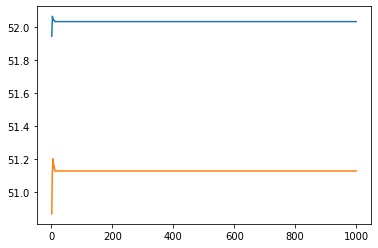

In [14]:
ep_li = sorted(list(set(ep_li)))
plt.plot(ep_li, acc_list)
plt.plot(ep_li, test_acc_list)
plt.show()